# Reference
https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/

In [227]:
import numpy as np
import cv2
import imutils

from scipy.spatial import distance
from matplotlib import pyplot as plt
from skimage.filters import threshold_local

(480, 355, 3)


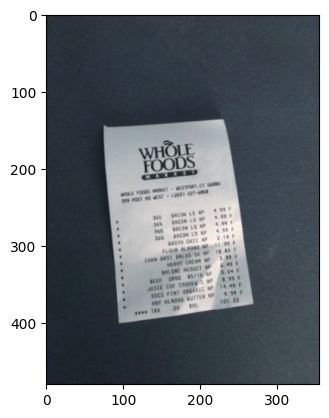

In [228]:
image = cv2.imread('../resources/document_scan_sample1.jpg')
print(image.shape)
plt.imshow(image)

## The reason for resize image:

`
In computer vision and image processing we rarely process images larger than 600 pixels along the maximum dimension. While high resolution images are appealing to the human eye they are simply too much detail for image processing algorithms. You can actually think of resizing an image as a form of “noise removal”. We discard much of the detail so we can focus our attention on a smaller version of the image that still contains the same contents — but with less “noise”, leading to much better results. - Adrian Rosebrock
`

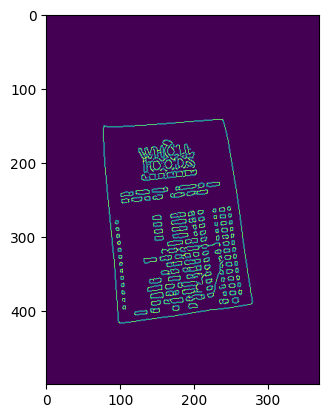

In [229]:
ratio = image.shape[0] / 500
orig = image.copy()
image = imutils.resize(image, height=500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 0)
edged = cv2.Canny(gray, 50, 100)

plt.imshow(edged)

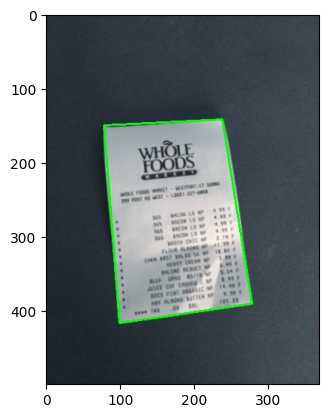

In [230]:
# get largest contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        screen_cnt = approx
        break
    
cv2.drawContours(image, [screen_cnt], -1, (0,255,0), 2)
plt.imshow(image)

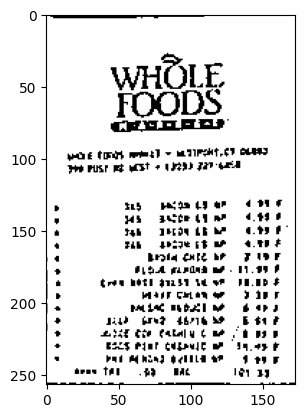

In [231]:
def order_points(points: np.ndarray):
    # initialize 4 points
    # top left, top right, bottom right, bottom left
    rect = np.zeros((4,2), dtype='float32')
    
    # get the top left and bottom right
    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]
    
    # get the top right and bottom left
    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]
    
    return rect

def four_point_transform(image, points):
    rect = order_points(points)
    tl, tr, br, bl = rect
    
    width_a = distance.euclidean(tl, tr)
    width_b = distance.euclidean(bl, br)
    max_width = max(int(width_a), int(width_b))
    
    height_a = distance.euclidean(tl, bl)
    height_b = distance.euclidean(tr, br)
    max_height = max(int(height_a), int(height_b))
    
    # open cv image coordinate system is start from top(0,0) to down
    dst = np.array([
        [0,0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype='float32')
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

warped = four_point_transform(orig, screen_cnt.reshape(4,2) * ratio)


warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, block_size=11, offset=10, method='gaussian')
# convert to white and black
warped = (warped > T).astype('uint8') * 255

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_GRAY2RGB))